## Discover media discourse in Spanish flu coverage with diachronic bi-gram clouds and topic modeling

## Step by step...

* [Packages](#1-bullet)
* [Import your newspaper collection](#2-bullet)
* [Clean, tokenize and lemmatize the text (pre-processing)](#3-bullet)
* [How did the discourse on the Spanish Flu change over the months?](#4-bullet)
* [What tpics can you find the in the newspaper coverage on the Spanish Flu?](#5-bullet)
* [Browse original texts](#6-bullet)


## Packages <a class="anchor" id="1-bullet"></a>

Before you can get started, you have to install and import some packages.

In [1]:
#languange processing imports
import gensim, spacy, logging, warnings
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from nltk.stem.porter import PorterStemmer
from gensim.utils import lemmatize, simple_preprocess
import gensim.corpora as corpora
import time
from gensim.models import LdaModel

#For the text overview
from nltk import FreqDist

#Word Cloud and Visualization

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

## Import your newspaper collection <a class="anchor" id="2-bullet"></a>


In [2]:
df = pd.read_csv('export_spanischegrippe_alle_05_03_2021_10_31.csv')
df_text = df['text']

<Figure size 1440x3600 with 0 Axes>

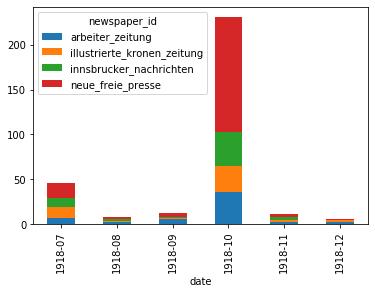

In [3]:
#Create a frequency graph using the publication date and the newspaper title

fig = plt.figure(figsize=(20,50))
df['date']=pd.to_datetime(df['date']).dt.strftime('%Y-%m')


fig = df.groupby(['date','newspaper_id']).size().unstack().plot(kind='bar',stacked=True)
plt.savefig('bar.png', dpi = 300)


## Clean, tokenize and lemmatize the text (pre-processing) <a class="anchor" id="3-bullet"></a>

Before you can start to train the bigram and trigram models, you have to clean the text of your newspaper text blocks. The follwing functions remove punctuations, lower case the text, remove stop words and stem the text. 



In [4]:
# Functions to clean, tokenize, and stem the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your own stop words
stop_words.extend(['ganz', 'ganzen', 'ganze', 'Grippe', 'Krankheit', 'Influenza', 'spanischen', 'spanische'])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

df['tokenized'] = df['text'].apply(apply_all) 

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts_out = []
    nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



data_ready1 = process_words(df['tokenized'])  # processed Text Data!

## How did the discourse on the Spanish flu change over the months? <a class="anchor" id="4-bullet"></a>

### Discover diachronic n-grams for specific years or time periods 

Here you can create diachronic Ngram clouds for specific years or time frames. 

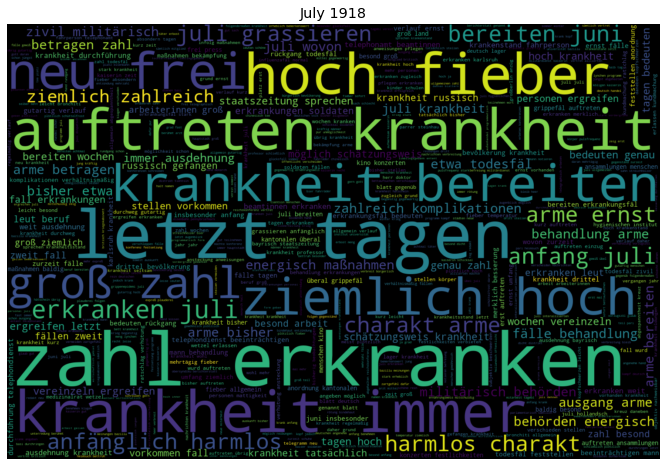

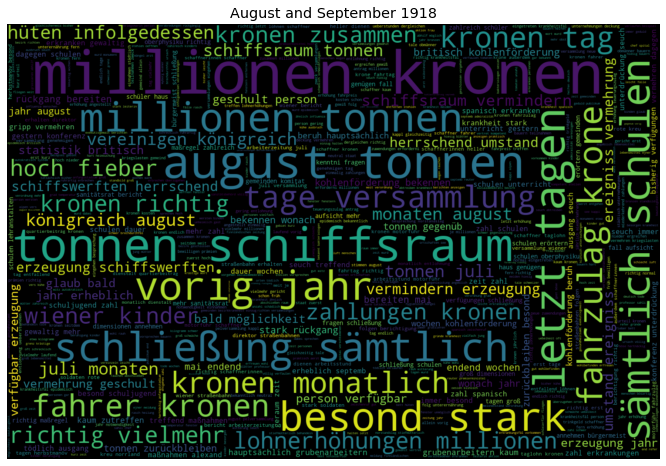

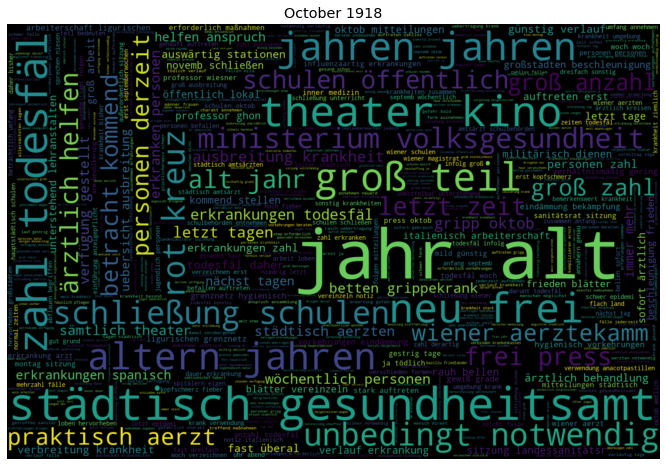

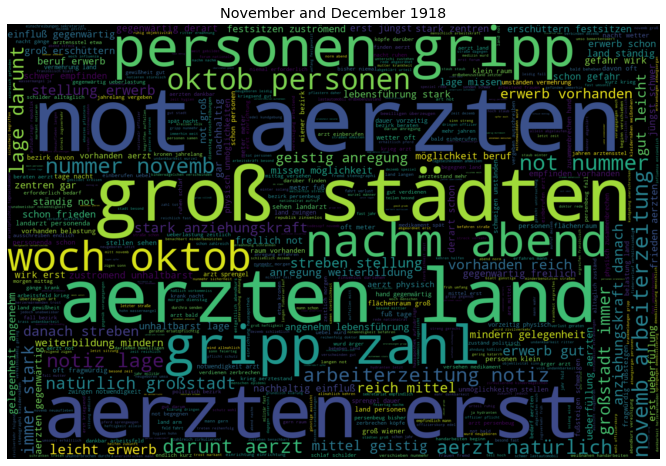

In [5]:
df['month']=(pd.to_datetime(df['date']).dt.strftime('%m'))
df['month'] = df['month'].astype(int)

july_1918 = (df['month'] > int('6')) & (df['month'] <= int('7'))
august_september_1918 = (df['month'] > int('7')) & (df['month'] <= int('9'))
october_1918 = (df['month'] > int('9')) & (df['month'] <= int('10'))
december_1918 = (df['month'] > int('10')) & (df['month'] <= int('12'))

#This will be used for the title of the clouds
time_frame = ['July 1918', 'August and September 1918', 'October 1918', 'November and December 1918']

#Here you create a list containing the information on your selected time-frames
selection = []
selection.append(july_1918)
selection.append(august_september_1918)
selection.append(october_1918)
selection.append(december_1918)

#Get your bigrams for every selected time frame
selection[0] = df.loc[july_1918]['tokenized']
selection[1] = df.loc[august_september_1918]['tokenized']
selection[2] = df.loc[october_1918]['tokenized']
selection[3] = df.loc[december_1918]['tokenized']

#Create the diachronic Ngram clouds
i = -1
while i < len(selection) -1:
    i = i +1 
    data_ready3 = process_words(selection[i])  # processed Text Data!
    bigrams_list = list(nltk.bigrams(data_ready3))
    dictionary = [' '.join([str(tup) for tup in bigrams_list])]
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(dictionary)
    vectorizer.vocabulary_
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_dict = dict(words_freq)
    WC_height = 1000
    WC_width = 1500
    WC_max_words = 500
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(words_dict)
    plt.figure(figsize=(15, 8))
    plt.plot
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.title(time_frame[i], size= 'x-large')
    plt.axis("off")
    plt.savefig('cloud.png', dpi = 300)
print()

## What kind of topics can you find the in the newspaper coverage on the Spanish flu? <a class="anchor" id="5-bullet"></a>

In [6]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    
    chunksize = 100
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   chunksize=chunksize, minimum_probability=0.0, passes=20, iterations=200, per_word_topics=True)
    t2 = time.time()
   # print("Time to train LDA model on ", len(train_df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

dictionary,corpus,lda = train_lda(data_ready1)

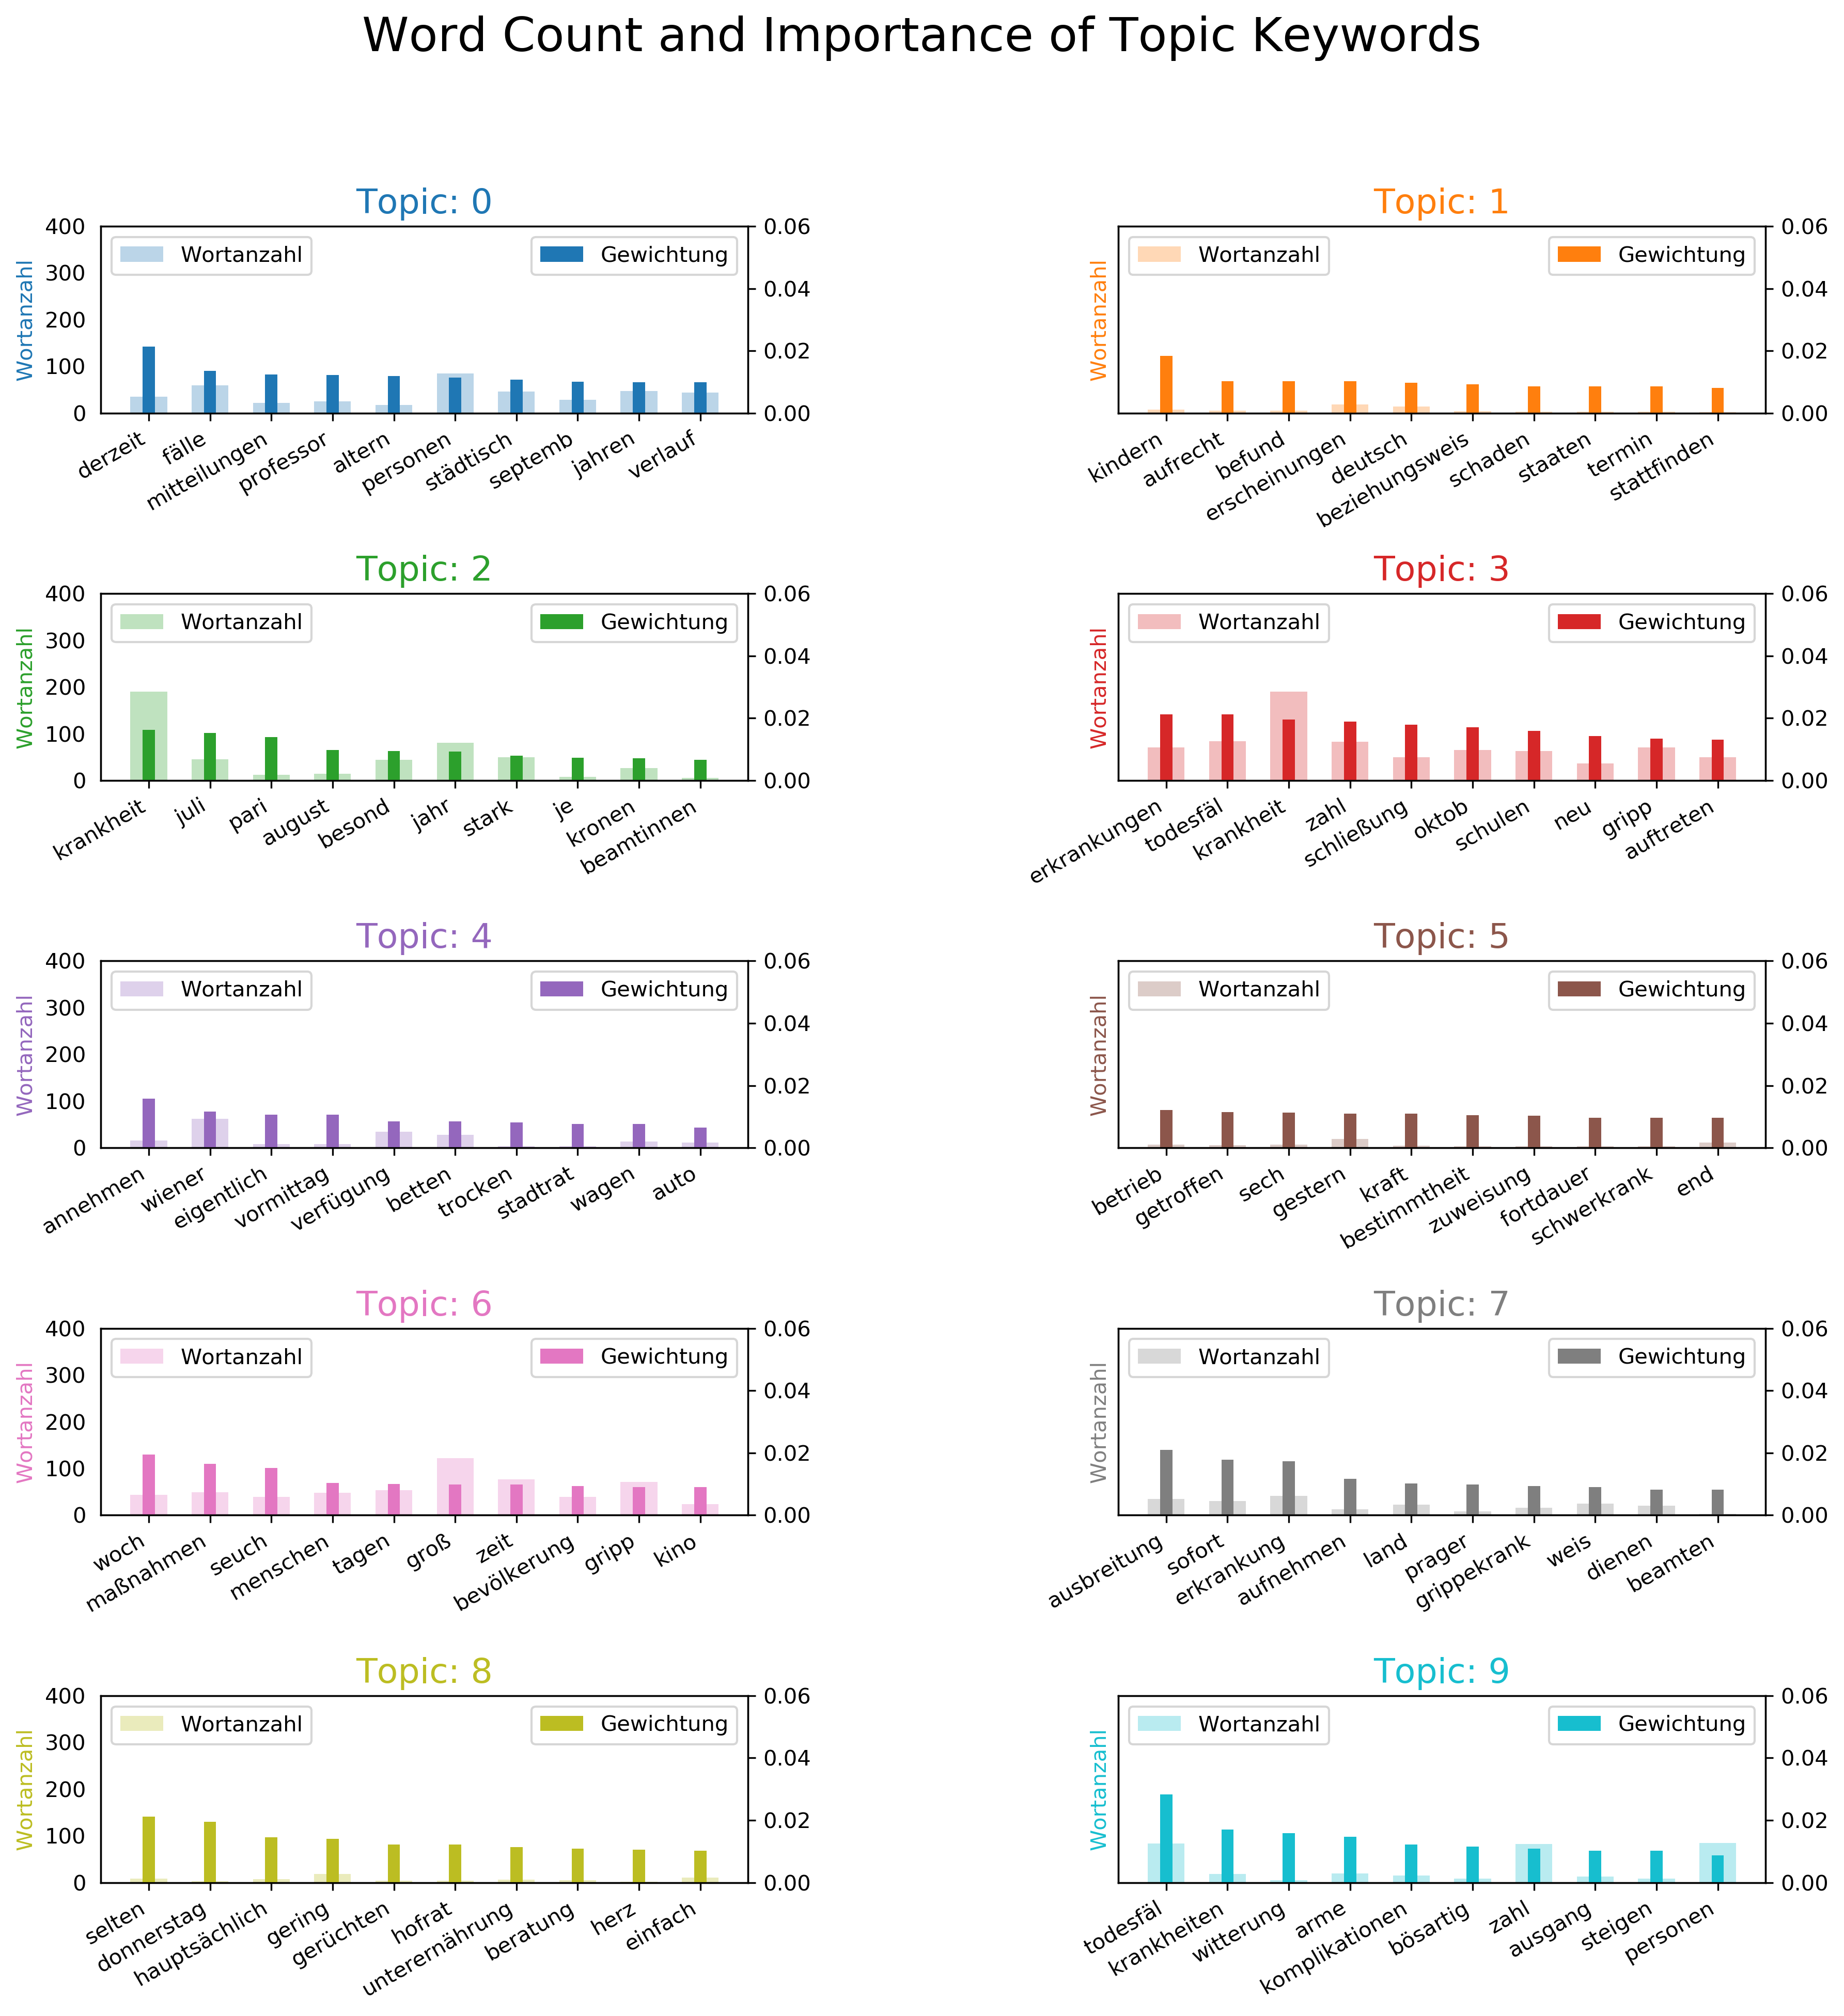

In [7]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in data_ready1 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(12,12), sharey=True, dpi=300)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.6, alpha=0.3, label='Wortanzahl')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Gewichtung')
    ax.set_ylabel('Wortanzahl', color=cols[i])
    ax_twin.set_ylim(0, 0.06); ax.set_ylim(0, 400)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=10)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.08)    
plt.show()

## Browse original texts <a class="anchor" id="6-bullet"></a>

Here you can browse through the original text. To refine the search, you can reduce the search to those texts that contain a specific word. In this example all texts were searched containg the word "amerika*". 

In [8]:
pd.set_option('display.max_colwidth', -1)


lines_ = []
for line in df_text:
    if 'Frauen' in line: #insert here the word you are looking for
        lines_.append(line)
    
lines_ = pd.DataFrame(lines_, columns =['text'])
df_select = pd.DataFrame(lines_['text'])
df_select[0:10]    


text
0  entgeltlichen Abendkurse der „Vereinigung der arbeitenden Frauen“ für fremde Sprachen, Stenographie, Maschinschreiben, Kleidernähen, Weißnähen, Handarbeiten, Frisieren u. a.,\nderen Beginn wegen der Epidemie verschoben wurde, werden nunmehr morgen Dienstag eröffnet. Einschreibungen im Sekretariat,\n1. Bezirk, Am Hof 11.\n[Empfindlicher Verlust.] Ein Mann, der schon acht\nJahre beim Militär dient und fast zwei Jahre im Felde war, hat\nwährend einer Fahrt 300 K. eingebüßt, die in Verlust gerieten oder\ngestohlen wurden. Er ist ersatzpflichtig und bittet, da er nichts besitzt\nund auf ein Tageseinkommen von 4 K. angewiesen ist, um Hilfe.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      